## Assignment 2
### Pradeep Mundlik AI21BTECH11022

In [1]:
import numpy as np
import torch
from torch.nn.functional import pad
from torchvision import transforms, datasets
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# dictionary of nonlinear functions
nonlinearity = {
    'sigmoid': lambda x: 1 / (1+torch.exp(-1*x)),
    'relu': lambda x: np.maximum(x, 0),
    'tanh': np.tanh,
    'prelu': lambda x: np.maximum(x, 0.1*x)
}


### Question-1: Convolution function

In [3]:
def conv(input, kernel, activation='relu', stride=1, padding=0):
    C, H, W = input.shape
    D, c, h, w = kernel.shape

    # number of channels in kernel and input should match
    if (c != C):
        raise ValueError(
            "kernel dimension and input dimension are incompatible")

    # if activation is wrong input then raise error
    if (activation not in nonlinearity.keys()):
        raise TypeError(
            f"activation should be from {list(nonlinearity.keys())}")

    # padding
    # if padding is just int like k then interpret as (k,k)
    if (np.ndim(padding) == 0):
        padding = (padding, padding)

    input = pad(input, (padding[1], padding[1],
                padding[0], padding[0]), value=0)

    # after padding shape of input will change
    C, H, W = input.shape
    # end padding

    # initializing output matrix
    output_height = int((H-h+1)/stride)
    output_width = int((W-w+1)/stride)
    output = torch.empty([D, output_height, output_width]).fill_(0)

    for d in range(D):
        for i in range(0, output_height):
            for j in range(0, output_width):
                temp = torch.mul(
                    input[:, i*stride:i*stride+h, j*stride:j*stride+w], kernel[d, :, :, :])
                output[d][i][j] = torch.sum(temp)

    output = nonlinearity[activation](output)
    return output


In [4]:
# input image used in this assignment
img = Image.open(
    '/home/pradeep/Documents/IITH_Academics/Deep_Learning/Assignment-2/Ecell.jpg')
transform = transforms.PILToTensor()
input = transform(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Shape - torch.Size([3, 900, 900])
Kernel Shape - torch.Size([3, 3, 10, 10])
Stride - 5 Padding - 2
Output Shape - torch.Size([3, 179, 179])


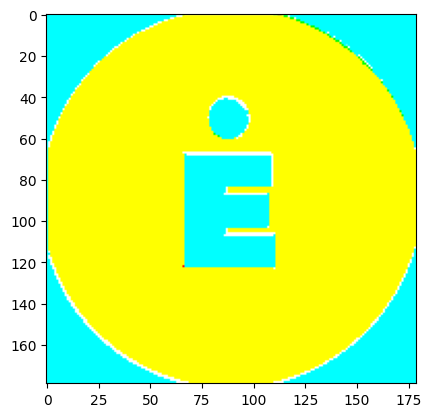

In [5]:
# trying conv function on imported image
kernel = torch.randn([3, 3, 10, 10])
conv_output = conv(input, kernel, activation='tanh', stride=5, padding=2)
plt.imshow(np.transpose(conv_output,(1,2,0)))
print("Input Shape -", input.shape)
print("Kernel Shape -", kernel.shape)
print("Stride -", 5, "Padding -", 2)
print("Output Shape -", conv_output.shape)


### Question-2: Pooling Function

In [6]:
def pooling(input, kernel_size, poolfunc='max', stride=None):

    # if argument poolfunc is not max or avg then raise error
    if (poolfunc not in ['max', 'avg']):
        raise ValueError("poolfunc must be either 'max' or 'avg'")

    C, H, W = input.shape

    # if kernel_size given is int like k then interpret as (k,k)
    if (np.ndim(kernel_size) == 0):
        kernel_size = (kernel_size, kernel_size)

    h, w = kernel_size

    # if stride given is int like k then interpret as (k,k)
    if (stride != None and np.ndim(stride) == 0):
        stride = (stride, stride)

    # if stride is None(i.e. not given by user) then assume it equals to kernel size. Assuming that stride can be different for both directions
    elif (stride == None):
        stride = (h, w)

    # initialize o/p matrix
    output_height = int(H/stride[0])
    output_width = int(W/stride[1])

    output = torch.empty([C, output_height, output_width]).fill_(0.0)

    # fill o/p matrix as per poolfunc
    for c in range(C):
        for i in range(output_height):
            for j in range(output_width):
                if (poolfunc == 'avg'):
                    output[c][i][j] = torch.mean(
                        input[c, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+h], dtype=float)
                else:
                    output[c][i][j] = torch.max(
                        input[c, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+h])

    return output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Shape - torch.Size([3, 179, 179])
Kernel Shape - (10, 10)
Output Shape - torch.Size([3, 17, 17])


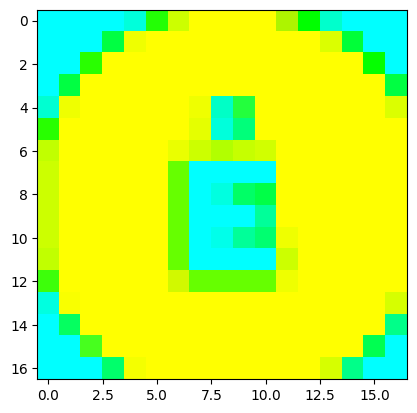

In [7]:
# using output of convolution as input for pooling
kernel_size = (10, 10)
pool_output = pooling(
    input=conv_output, kernel_size=kernel_size, poolfunc='avg')
plt.imshow(np.transpose(pool_output,(1,2,0)))
print("Input Shape -", conv_output.shape)
print("Kernel Shape -", kernel_size)
print("Output Shape -", pool_output.shape)


### Question-3: Convolution layer function

In [8]:
def convlayer(input, out_channels, kernel_size, activation='relu', stride=1, padding=0):

    # if kernel_size given is int like k then interpret as (k,k)
    if (np.ndim(kernel_size) == 0):
        kernel_size = (kernel_size, kernel_size)

    h, w = kernel_size

    # randnomly initializing kernel
    kernel = torch.randn([out_channels, input.shape[0], h, w])

    # calling convolution function and returning result
    return conv(input, kernel, activation, stride, padding)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Shape - torch.Size([3, 900, 900])
Kernel Shape - (10, 10)
Output Shape - torch.Size([3, 179, 179])


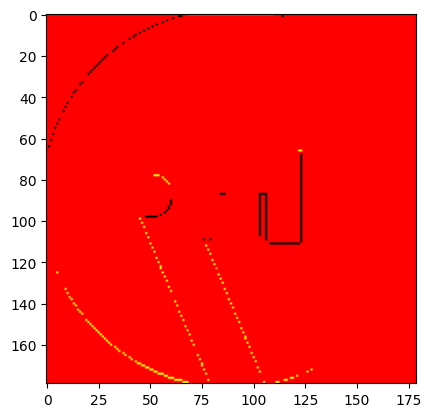

In [9]:
# trying conv layer function on imported image
kernel_size = (10, 10)
conv_output = convlayer(input, out_channels=3,
                        kernel_size=kernel_size, activation='relu',stride=5,padding=2)
plt.imshow(np.transpose(conv_output,(2,1,0)))
print("Input Shape -", input.shape)
print("Kernel Shape -", kernel_size)
print("Output Shape -", conv_output.shape)


### Question-4: Pooling layer function

In [10]:
# funtion for Global Avg Pooling of 2D or 3D matrix
def globalavg_pool(input):

    # if input is 2D
    if (np.ndim(input) == 2):
        return torch.mean(input, 1)

    # if input is 3D
    if (np.ndim(input) == 3):
        input = torch.Tensor.float(input)
        output = torch.mean(input, 0)
        output = torch.mean(output, 0)
        return output

    else:
        raise ValueError(
            f'Inapropriate input dimension. Can be either 2D or 3D but found {np.ndim(input)}D')


In [11]:
# pooling layer function puts all pooling functions together
# if GAP(bool)=True then if calls globalavg_pool function for GAP of input (in this case we don't need kernel size and that's why default is None)
# else it calls pooling function for max or mean pooling (here kernel size is must, so we raise error if kernel size is not there)
def poolinglayer(input, GAP=False, kernel_size=None, poolfunc='max', stride=None):

    if (GAP):
        return globalavg_pool(input)

    if (kernel_size == None):
        raise ValueError(
            "Either make GAP=True for Global Avg Pooling or give kernel_size for normal pooling")

    return pooling(input, kernel_size, poolfunc=poolfunc, stride=stride)


In [12]:
# calling pool layer function for avg pooling on output of conv layer function
# GAP here is False (default)
pool_output = poolinglayer(
    input=conv_output, kernel_size=10, stride=10, poolfunc='avg')
print("Input Shape -", conv_output.shape)
print("Output Shape -", pool_output.shape)


Input Shape - torch.Size([3, 179, 179])
Output Shape - torch.Size([3, 17, 17])


In [13]:
# calling pool layer function for global avg pooling of output of avg pooling (o/p of previous cell)
# note that after putting GAP=True, we don't need to give any other arguments
gap_output = poolinglayer(input=pool_output, GAP=True)
print("Input Shape -", pool_output.shape)
print("Output Shape -", gap_output.shape)


Input Shape - torch.Size([3, 17, 17])
Output Shape - torch.Size([17])


### Question-5: Flattening

In [14]:
def flatten(input, output_size):
    input = torch.reshape(input, (-1,))
    input = torch.Tensor.float(input)
    weight = torch.randn([output_size, input.shape[0]])

    output = torch.matmul(weight, input)
    return output


In [15]:
# calling flatten on o/p of pool layer function
flat_output = flatten(input=pool_output, output_size=400)
print("Input Shape -", pool_output.shape)
print("Output Shape -", flat_output.shape)


Input Shape - torch.Size([3, 17, 17])
Output Shape - torch.Size([400])


### Question-6: Multilayer Perceptron function

In [16]:
# function for softmax transformation
def softmax(input):
    input = torch.exp(input)
    sum = torch.sum(input)
    input = input/sum
    return input


In [17]:
# here default activation is sigmoid
# use_softmax=False denotes not to apply softmax transformation on output, default is True
def MLP(input, number_of_hiddenlayers, hiddenlayer_size, output_size, activation='sigmoid', use_softmax=True):

    if (activation not in nonlinearity.keys()):
        raise TypeError(
            f"activation should be from {list(nonlinearity.keys())}")

    # if hiddenlayer_size is int like k then interpret it as [k]
    if (np.ndim(hiddenlayer_size) == 0):
        hiddenlayer_size = [hiddenlayer_size]

    # if number of hidden layers and length of list of sizes of hidden layers doesn't match then raise error
    if (len(hiddenlayer_size) != number_of_hiddenlayers):
        raise ValueError(
            "Size of hidden layers or number of hidden layers are not valid")

    # appending o/p size in hiddenlayer_size for simplicity in for loop
    hiddenlayer_size.append(output_size)

    output = input

    for i in range(number_of_hiddenlayers+1):
        weight = torch.randn((output.shape[0], hiddenlayer_size[i]))
        output = torch.matmul(output, weight)
        output = nonlinearity[activation](output)

    if (use_softmax):
        output = softmax(output)

    return output


In [18]:
# calling MLP on output of flatten function
mlp_output = MLP(input=flat_output, number_of_hiddenlayers=3, hiddenlayer_size=[
                 512, 128, 32], output_size=5, activation='tanh', use_softmax=False)
mlp_output

tensor([-0.9996,  0.9970, -1.0000,  0.8471, -1.0000])

### Question-7: Feed-forward path

In [19]:
# bottleneck(bool)==True denotes that user need bottelneck layer (layer just before applying GAP) as return along with output. Default is False
def forwardpath(input, output_dim, bottelneck=False):

    conv_output_1 = convlayer(
        input=input, out_channels=16, kernel_size=3, activation='sigmoid')
    # no need of giving stride specially as default stride is kernel size
    pool_output_1 = poolinglayer(input=conv_output_1, kernel_size=2)

    conv_output_2 = convlayer(
        input=pool_output_1, out_channels=8, kernel_size=3, activation='sigmoid')
    pool_output_2 = poolinglayer(input=conv_output_2, kernel_size=2)

    gap_output = poolinglayer(
        input=pool_output_2, GAP=True)  # bottelneck layer
    output = MLP(input=gap_output, number_of_hiddenlayers=1, hiddenlayer_size=[
                 gap_output.shape[0]], output_size=output_dim, activation='sigmoid', use_softmax=True)

    if (bottelneck):
        return output, gap_output

    return output

##### Importing Dataset

In [20]:
dataset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


0.3%


KeyboardInterrupt: 

##### Plotting some images

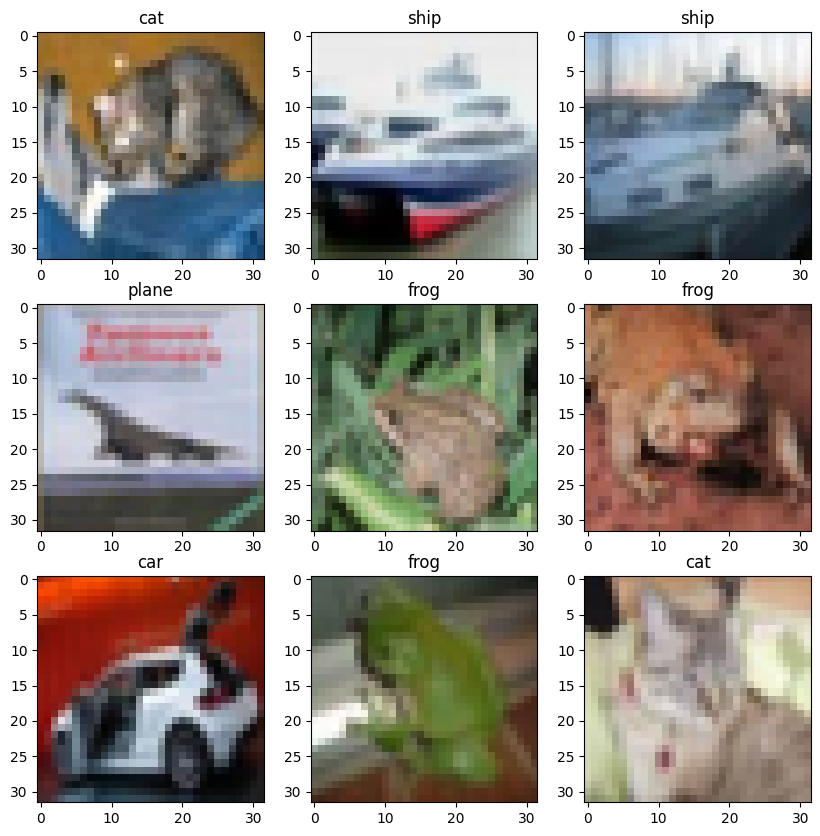

In [ ]:
# get some randnom training images
dataiter = iter(dataloader)
# show images
plt.figure(figsize=[10, 10])

for i in range(9):
    image, label = next(dataiter)
    plt.subplot(3, 3, 1+i)
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    plt.title(classes[label])
plt.show()


In [ ]:
# Passing one image to forward path
image, label = next(dataiter)
output = forwardpath(input=image[0], output_dim=10)
print("Output Vector -", output)
print("Output Shape -", output.shape)
print("Sum of all elements in output -", torch.sum(output))


Output Vector - tensor([0.0798, 0.0844, 0.1045, 0.1254, 0.0816, 0.0944, 0.1083, 0.0861, 0.1190,
        0.1164])
Output Shape - torch.Size([10])
Sum of all elements in output - tensor(1.)


### Question-8 (a)

In [ ]:
# passing image from each class to forwardpath function
# converting datasets to numpy object for simplicity
dataset = np.array(dataset)

for i in range(10):
    # selecting one image with label i
    input = dataset[dataset[:, 1] == i][0]

    output = forwardpath(input=input[0], output_dim=10)

    print(f"Output Vector for label {i}({classes[i]}) -", output)
    print(f"output[{i}] -", output[i].item())
    print(f"max element in output -", torch.max(output).item())
    print("\n")


/tmp/ipykernel_12082/602603763.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  dataset = np.array(dataset)
/tmp/ipykernel_12082/602603763.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)


Output Vector for label 0(plane) - tensor([0.0700, 0.1051, 0.1032, 0.1369, 0.1047, 0.0736, 0.0986, 0.1330, 0.0618,
        0.1131])
output[0] - 0.06999521702528
max element in output - 0.13686613738536835


Output Vector for label 1(car) - tensor([0.0974, 0.1173, 0.0557, 0.1295, 0.0875, 0.1114, 0.0535, 0.1075, 0.1305,
        0.1097])
output[1] - 0.11728490144014359
max element in output - 0.13054285943508148


Output Vector for label 2(bird) - tensor([0.1182, 0.0910, 0.1293, 0.0528, 0.1003, 0.1130, 0.0931, 0.1334, 0.0602,
        0.1088])
output[2] - 0.12930339574813843
max element in output - 0.13338306546211243


Output Vector for label 3(cat) - tensor([0.1104, 0.1344, 0.0680, 0.0961, 0.0749, 0.1068, 0.1042, 0.0926, 0.1145,
        0.0980])
output[3] - 0.09610646218061447
max element in output - 0.13443319499492645


Output Vector for label 4(deer) - tensor([0.1069, 0.0849, 0.0757, 0.0692, 0.1223, 0.1242, 0.1345, 0.0860, 0.0752,
        0.1210])
output[4] - 0.12225545197725296
max e

* <math>Here, we can see that output for $i^{th}$ label have its $i^{th}$ element either as maximum element of vector or near to maximum element in vector </math>

### Question-8 (b)

In [ ]:
data = []

for i in range(10):

    input = dataset[dataset[:, 1] == i][:3]

    for j in range(3):

        output, bottlenecklayer = forwardpath(
            input=input[j][0], output_dim=10, bottelneck=True)

        bottlenecklayer = np.array(bottlenecklayer)

        data.append(bottlenecklayer)

data = np.array(data)
pca = PCA(n_components=2)
data = pca.fit_transform(data)


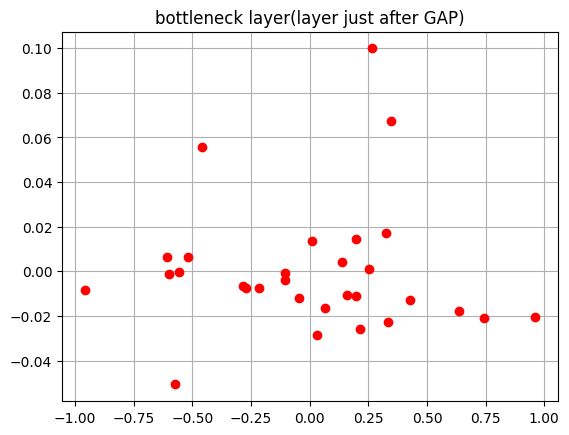

In [ ]:
plt.plot(data[:, 0], data[:, 1], 'ro')
plt.grid()
plt.title('bottleneck layer(layer just after GAP)')
plt.show()
